# Práctica 2: GPU Programming (CUDA)

### Autores:
* Rafael Domínguez Sáez

* Iñigo Martínez Ciriza

# Preparación del entorno

Antes de nada debemos preparar el entorno de ejecución.

Eliminación de datos innecesarios creados por Google Collab:

In [30]:
!rm -rf sample_data

Descarga de `Numba` en caso de no encontrarse en el sistema:

In [31]:
!pip install numba --upgrade

Importación de los paquetes necesarios para el correcto funcionamiento del código:

In [32]:
import numpy as np
from numba import cuda, float32
import time
import math
import matplotlib.pyplot as plt

# 2.1 Compulsory assignment #1: Matrix transpose

In [33]:
Ax = 5_000
Ay = 7_000
Bx = Ay
By = Ax

def create_matrix_1(Ax: int, Ay: int) -> tuple:
  return np.random.rand(Ax, Ay), np.zeros((Ay, Ax))

In [34]:
@cuda.jit
def transpose_parallel(A, B):
    i, j = cuda.grid(2)
    if i < B.shape[0] and j < B.shape[1]:
        B[i, j] = A[j, i]

def transpose_sequential(A, B):
    for i in range(0, B.shape[0]):
        for j in range(0, B.shape[1]):
            B[i, j] = A[j, i]

In [35]:
A, B_seq = create_matrix_1(Ax, Ay)

t_start = time.time()
transpose_sequential(A, B_seq)
t_finish = time.time()

t_cpu = t_finish - t_start

print(f"Input \n", A)
print()
print(f"Output \n", B_seq)
print()
print(f"Tiempo ejecución en CPU = {t_cpu} s")

Input 
 [[0.96281539 0.92074715 0.99599567 ... 0.14838641 0.44671241 0.29474659]
 [0.36898301 0.47201414 0.95449933 ... 0.48447672 0.32944983 0.27712377]
 [0.65535882 0.41264603 0.24518238 ... 0.27815725 0.91630201 0.98327132]
 ...
 [0.88152434 0.93613665 0.84549655 ... 0.66459876 0.83080615 0.92085803]
 [0.93327605 0.44366224 0.19803946 ... 0.86205745 0.08057108 0.64607204]
 [0.72099475 0.02099114 0.57698918 ... 0.50933453 0.82075662 0.27867729]]

Output 
 [[0.96281539 0.36898301 0.65535882 ... 0.88152434 0.93327605 0.72099475]
 [0.92074715 0.47201414 0.41264603 ... 0.93613665 0.44366224 0.02099114]
 [0.99599567 0.95449933 0.24518238 ... 0.84549655 0.19803946 0.57698918]
 ...
 [0.14838641 0.48447672 0.27815725 ... 0.66459876 0.86205745 0.50933453]
 [0.44671241 0.32944983 0.91630201 ... 0.83080615 0.08057108 0.82075662]
 [0.29474659 0.27712377 0.98327132 ... 0.92085803 0.64607204 0.27867729]]

Tiempo ejecución en CPU = 16.853273391723633 s


In [36]:
_, B_par = create_matrix_1(Ax, Ay)

A_device = cuda.to_device(A)
B_device = cuda.to_device(B_par)

threads_per_block = (16, 16)

blocks_X = math.ceil(B_par.shape[0] / threads_per_block[0])
blocks_Y = math.ceil(B_par.shape[1] / threads_per_block[1])
blocks_total = (blocks_X, blocks_Y)

t_start = time.time()

transpose_parallel[blocks_total, threads_per_block](A_device, B_device)

t_finish = time.time()

B_par = B_device.copy_to_host()

t_gpu = t_finish - t_start

print("Input \n", A)
print()
print("Otuput \n", B_par)
print()
print(f"Tiempo ejecución en GPU = {t_gpu} s")

Input 
 [[0.96281539 0.92074715 0.99599567 ... 0.14838641 0.44671241 0.29474659]
 [0.36898301 0.47201414 0.95449933 ... 0.48447672 0.32944983 0.27712377]
 [0.65535882 0.41264603 0.24518238 ... 0.27815725 0.91630201 0.98327132]
 ...
 [0.88152434 0.93613665 0.84549655 ... 0.66459876 0.83080615 0.92085803]
 [0.93327605 0.44366224 0.19803946 ... 0.86205745 0.08057108 0.64607204]
 [0.72099475 0.02099114 0.57698918 ... 0.50933453 0.82075662 0.27867729]]

Otuput 
 [[0.96281539 0.36898301 0.65535882 ... 0.88152434 0.93327605 0.72099475]
 [0.92074715 0.47201414 0.41264603 ... 0.93613665 0.44366224 0.02099114]
 [0.99599567 0.95449933 0.24518238 ... 0.84549655 0.19803946 0.57698918]
 ...
 [0.14838641 0.48447672 0.27815725 ... 0.66459876 0.86205745 0.50933453]
 [0.44671241 0.32944983 0.91630201 ... 0.83080615 0.08057108 0.82075662]
 [0.29474659 0.27712377 0.98327132 ... 0.92085803 0.64607204 0.27867729]]

Tiempo ejecución en GPU = 0.13408303260803223 s


In [37]:
speedup = t_cpu / t_gpu

print(f"Speedup = {speedup}")

Speedup = 125.69281186375882


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


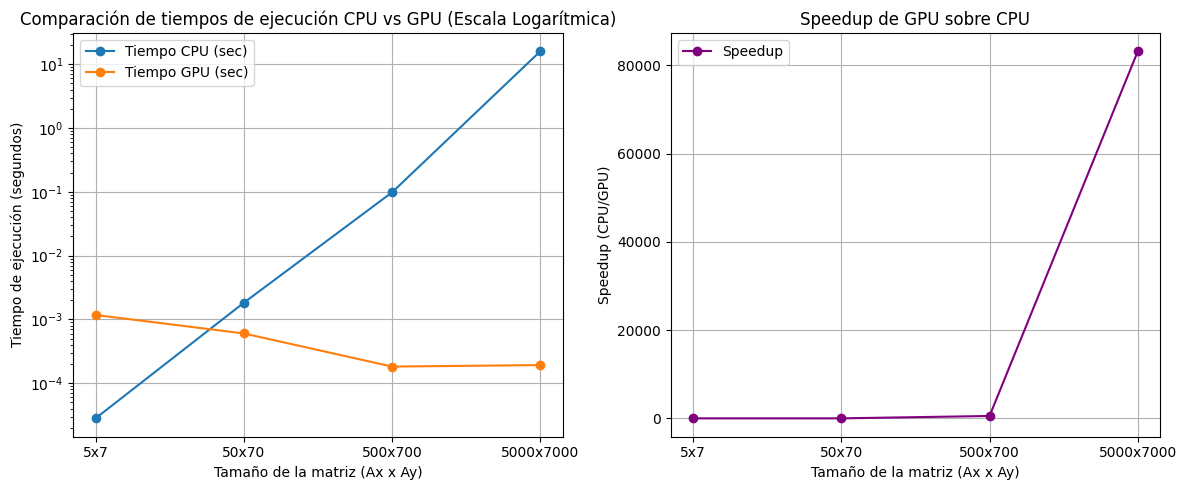

In [38]:
time_cpu = []
time_gpu = []
Ax_list = [5,50,500,5_000]
Ay_list = [7,70,700,7_000]

for Ax, Ay in zip(Ax_list, Ay_list):
    A, B = create_matrix_1(Ax, Ay)

    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)

    threads_per_block = (16, 16)

    blocks_X = math.ceil(B.shape[0] / threads_per_block[0])
    blocks_Y = math.ceil(B.shape[1] / threads_per_block[1])
    blocks_total = (blocks_X, blocks_Y)

    t_start = time.time()
    transpose_parallel[blocks_total, threads_per_block](A_device, B_device)
    t_finish = time.time()

    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    transpose_sequential(A, B)
    t_finish = time.time()

    time_cpu.append(t_finish-t_start)

speedup = np.array(time_cpu) / np.array(time_gpu)

matrix_sizes = [f"{Ax}x{Ay}" for Ax, Ay in zip(Ax_list, Ay_list)]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(matrix_sizes, time_cpu, label='Tiempo CPU (sec)', marker='o')
ax1.plot(matrix_sizes, time_gpu, label='Tiempo GPU (sec)', marker='o')
ax1.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución CPU vs GPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax2.set_ylabel("Speedup (CPU/GPU)")
ax2.set_title("Speedup de GPU sobre CPU")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Explicaciones

La primera gráfica, en escala logarítmica, revela que el tiempo de ejecución en CPU aumenta exponencialmente con el tamaño de la matriz. En contraste, el tiempo de ejecución en GPU permanece relativamente constante y mucho más bajo. Esto destaca la eficiencia de la GPU en la ejecución de operaciones en paralelo, especialmente a medida que el tamaño de la matriz aumenta.

La segunda gráfica muestra el factor de aceleración (speedup) de la GPU sobre la CPU para cada tamaño de matriz. Para matrices pequeñas, el speedup es bajo, ya que la ventaja de la GPU no es tan evidente. Sin embargo, al llegar a matrices más grandes, el speedup aumenta significativamente, lo cual indica que la GPU es cada vez más ventajosa en comparación con la CPU en términos de velocidad para matrices grandes.

# 2.2 Compulsory assignment #2: Average Rows/Cols I

In [39]:
def Avg_Cols_sequential(input, output):
    for y in range(input.shape[1]):
        output[y] = 0.0
        for x in range(input.shape[0]):
            output[y] += input[x, y]
        output[y] /= input.shape[0]

def Avg_Rows_sequential(input, output):
    for y in range(input.shape[0]):
        output[y] = 0.0
        for x in range(input.shape[1]):
            output[y] += input[y, x]
        output[y] /= input.shape[1]

@cuda.jit
def Avg_Cols_parallel(input, output):
    y = cuda.grid(1)

    if y < input.shape[1]:
        sum_val = 0.0
        for x in range(input.shape[0]):
            sum_val += input[x, y]
        output[y] = sum_val / input.shape[0]

@cuda.jit
def Avg_Rows_parallel(input, output):
    y = cuda.grid(1)

    if y < input.shape[0]:
        sum_val = 0.0
        for x in range(input.shape[1]):
            sum_val += input[y, x]
        output[y] = sum_val / input.shape[1]


In [40]:
np.random.seed(0)

Ax = 4_000
Ay = 4_000

A = np.random.rand(Ax, Ay)

# CPU
B_cpu_cols = np.zeros(Ay)

t_start = time.time()
Avg_Cols_sequential(A, B_cpu_cols)
t_finish = time.time()

t_cpu_cols = t_finish - t_start

print("Input \n", A)
print()
print("Output CPU \n", B_cpu_cols)
print()
print(f"Tiempo ejecución en CPU = {t_cpu_cols} s")
print()

# GPU
B_gpu_cols = np.zeros(Ay)

A_device = cuda.to_device(A)
B_device = cuda.to_device(B_gpu_cols)

threads_per_block = 32
blocks_total = math.ceil(A_device.shape[1] / threads_per_block)

t_start = time.time()
Avg_Cols_parallel[blocks_total, threads_per_block](A_device, B_device)
t_finish = time.time()

B_gpu_cols = B_device.copy_to_host()
t_gpu_cols = t_finish - t_start

print("Output GPU \n", B_gpu_cols)
print()
print(f"Tiempo ejecución en GPU = {t_gpu_cols} s")
print()

# Speedup
speedup = t_cpu_cols / t_gpu_cols
print(f"Speedup = {speedup}")

Input 
 [[0.5488135  0.71518937 0.60276338 ... 0.83000295 0.93280618 0.30833843]
 [0.29264205 0.56651827 0.13741443 ... 0.80182819 0.5391446  0.83721853]
 [0.4577597  0.3769177  0.70233513 ... 0.84348096 0.94290928 0.83282242]
 ...
 [0.45568019 0.05480491 0.25982542 ... 0.10151857 0.47639488 0.7728146 ]
 [0.47772193 0.61759916 0.66554051 ... 0.63370207 0.7252492  0.75827622]
 [0.2176855  0.35912559 0.78489484 ... 0.25148401 0.36997825 0.72145565]]

Output CPU 
 [0.49843221 0.49760128 0.49841932 ... 0.50760745 0.50385554 0.50377579]

Tiempo ejecución en CPU = 6.26396918296814 s



/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 125 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Output GPU 
 [0.49843221 0.49760128 0.49841932 ... 0.50760745 0.50385554 0.50377579]

Tiempo ejecución en GPU = 0.21338582038879395 s

Speedup = 29.355133211546303


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


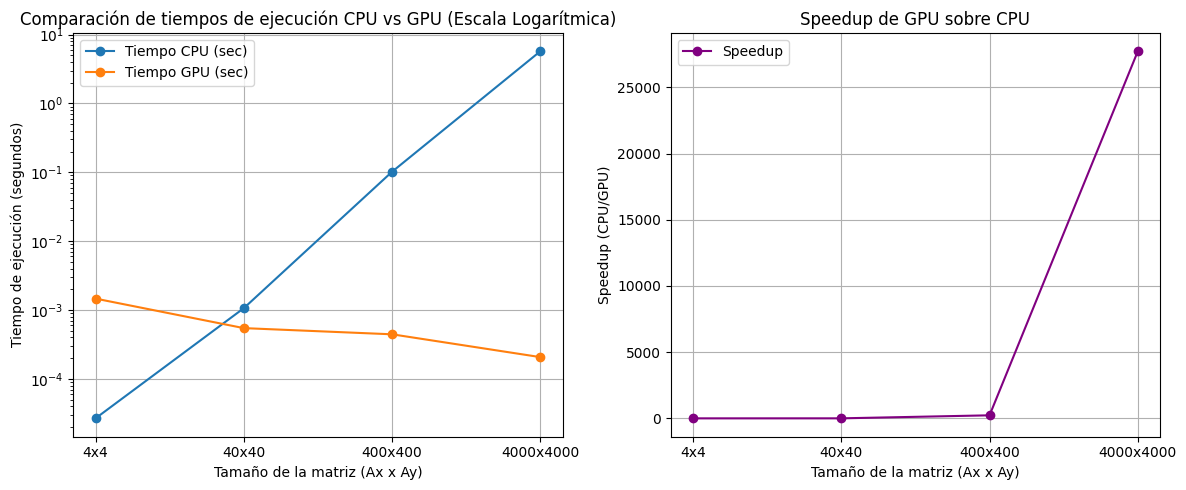

In [41]:
time_cpu = []
time_gpu = []
Ax_list = [4,40,400,4_000]
Ay_list = [4,40,400,4_000]

for Ax, Ay in zip(Ax_list, Ay_list):
    A = np.random.rand(Ax, Ay)
    B = np.zeros(Ay)

    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)

    threads_per_block = 32
    blocks_total = math.ceil(A_device.shape[1] / threads_per_block)

    t_start = time.time()
    Avg_Cols_parallel[blocks_total, threads_per_block](A_device, B_device)
    t_finish = time.time()

    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Avg_Cols_sequential(A, B_cpu_cols)
    t_finish = time.time()

    time_cpu.append(t_finish-t_start)

speedup = np.array(time_cpu) / np.array(time_gpu)

matrix_sizes = [f"{Ax}x{Ay}" for Ax, Ay in zip(Ax_list, Ay_list)]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(matrix_sizes, time_cpu, label='Tiempo CPU (sec)', marker='o')
ax1.plot(matrix_sizes, time_gpu, label='Tiempo GPU (sec)', marker='o')
ax1.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución CPU vs GPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax2.set_ylabel("Speedup (CPU/GPU)")
ax2.set_title("Speedup de GPU sobre CPU")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [42]:
# CPU
B_cpu_rows = np.zeros(Ax)

t_start = time.time()
Avg_Rows_sequential(A, B_cpu_rows)
t_finish = time.time()

t_cpu_rows = t_finish - t_start

print("Input \n", A)
print()
print("Output CPU \n", B_cpu_rows)
print()
print(f"Tiempo ejecución en CPU = {t_cpu_rows} s")
print()

# GPU
B_gpu_rows = np.zeros(Ax)

A_device = cuda.to_device(A)
B_device = cuda.to_device(B_gpu_rows)

threads_per_block = 32
blocks_total = math.ceil(A_device.shape[0] / threads_per_block)

t_start = time.time()
Avg_Rows_parallel[blocks_total, threads_per_block](A_device, B_device)
cuda.synchronize()
t_finish = time.time()

B_gpu_rows = B_device.copy_to_host()
t_gpu_rows = t_finish - t_start

print("Output GPU \n", B_gpu_rows)
print()
print(f"Tiempo ejecución en GPU = {t_gpu_rows} s")
print()

# Speedup
speedup = t_cpu_rows / t_gpu_rows
print(f"Speedup = {speedup}")

Input 
 [[0.21165623 0.11758507 0.8899926  ... 0.60865864 0.96048905 0.03548291]
 [0.92355723 0.59093637 0.79158456 ... 0.42521748 0.08007057 0.15973984]
 [0.82233905 0.73838828 0.36441145 ... 0.33881956 0.12856675 0.45056871]
 ...
 [0.80223584 0.81430126 0.04833948 ... 0.89669794 0.75292834 0.7459204 ]
 [0.83707276 0.05168799 0.44154744 ... 0.62679947 0.36852652 0.21272571]
 [0.27329947 0.66661769 0.31297373 ... 0.91180839 0.56883728 0.79221972]]

Output CPU 
 [0.49362058 0.49473222 0.4963109  ... 0.49711769 0.50708163 0.50367516]

Tiempo ejecución en CPU = 6.827451467514038 s

Output GPU 
 [0.49362058 0.49473222 0.4963109  ... 0.49711769 0.50708163 0.50367516]

Tiempo ejecución en GPU = 0.12545108795166016 s

Speedup = 54.42321448933825


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 125 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


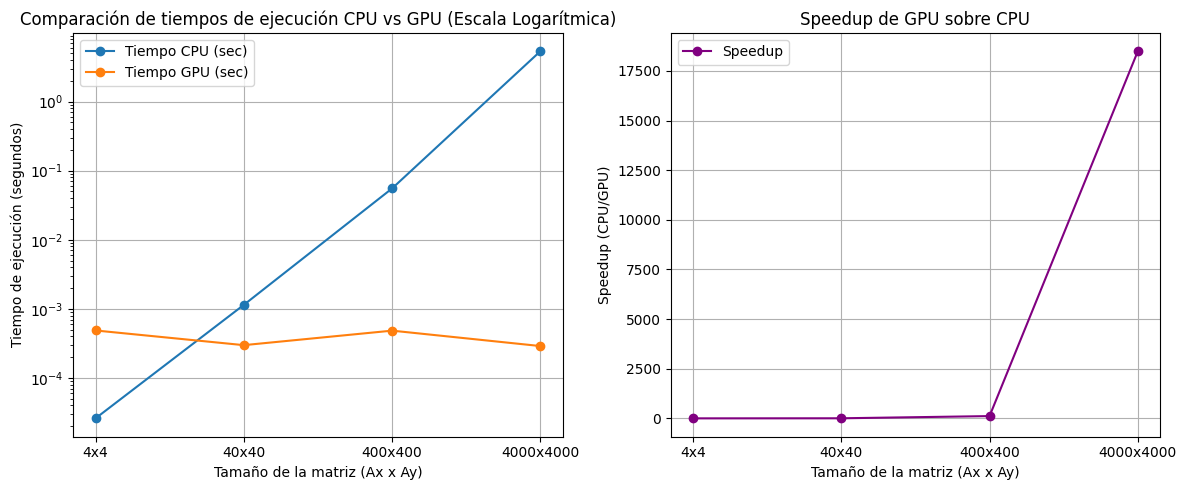

In [43]:
time_cpu = []
time_gpu = []
Ax_list = [4,40,400,4_000]
Ay_list = [4,40,400,4_000]

for Ax, Ay in zip(Ax_list, Ay_list):
    A = np.random.rand(Ax, Ay)
    B = np.zeros(Ay)

    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)

    threads_per_block = 32
    blocks_total = math.ceil(A_device.shape[1] / threads_per_block)

    t_start = time.time()
    Avg_Rows_parallel[blocks_total, threads_per_block](A_device, B_device)
    t_finish = time.time()

    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Avg_Rows_sequential(A, B)
    t_finish = time.time()

    time_cpu.append(t_finish-t_start)

speedup = np.array(time_cpu) / np.array(time_gpu)

matrix_sizes = [f"{Ax}x{Ay}" for Ax, Ay in zip(Ax_list, Ay_list)]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(matrix_sizes, time_cpu, label='Tiempo CPU (sec)', marker='o')
ax1.plot(matrix_sizes, time_gpu, label='Tiempo GPU (sec)', marker='o')
ax1.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución CPU vs GPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax2.set_ylabel("Speedup (CPU/GPU)")
ax2.set_title("Speedup de GPU sobre CPU")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# 2.3 Compulsory assignment #3: Average Rows/Cols II (2 points)

In [44]:
@cuda.jit
def Avg_Cols_parallel_shared(input, output):
    shared_mem = cuda.shared.array(shape=(32,), dtype=float32)
    rows, cols = input.shape
    y = cuda.grid(1)
    tx = cuda.threadIdx.x

    if y < cols:
        shared_mem[tx] = 0.0
        cuda.syncthreads()
        for x in range(rows):
            cuda.atomic.add(shared_mem, tx, input[x, y])
        cuda.syncthreads()
        output[y] = shared_mem[tx] / rows

@cuda.jit
def Avg_Rows_parallel_shared(input, output):
    shared_mem = cuda.shared.array(shape=(32,), dtype=float32)
    rows, cols = input.shape
    x = cuda.grid(1)
    tx = cuda.threadIdx.x

    if tx < rows:
        shared_mem[tx] = 0.0
        cuda.syncthreads()
        for y in range(cols):
            cuda.atomic.add(shared_mem, tx, input[x, y])
        cuda.syncthreads()
        output[x] = shared_mem[tx] / cols

In [45]:
# GPU SHARED
B_gpu_cols_shared = np.zeros(Ay)

B_device = cuda.to_device(B_gpu_cols_shared)

threads_per_block = 32
blocks_total = math.ceil(A_device.shape[1] / threads_per_block)

t_start = time.time()
Avg_Cols_parallel_shared[blocks_total, threads_per_block](A_device, B_device)
t_finish = time.time()

B_gpu_cols_shared = B_device.copy_to_host()
t_gpu_cols_shared = t_finish - t_start

print("Output GPU \n", B_gpu_cols)
print()
print("Output GPU memoria compartida \n", B_gpu_cols_shared)
print()
print(f"Tiempo ejecución en GPU con memoria compartida = {t_gpu_cols_shared} s")
print()

# Speedup
speedup = t_cpu_cols / t_gpu_cols_shared
print(f"Speedup = {speedup}")

speedup = t_gpu_cols / t_gpu_cols_shared
print(f"Speedup memoria compartida = {speedup}")

Output GPU 
 [0.49843221 0.49760128 0.49841932 ... 0.50760745 0.50385554 0.50377579]

Output GPU memoria compartida 
 [0.49596951 0.50170972 0.4967226  ... 0.5037131  0.50246237 0.50077753]

Tiempo ejecución en GPU con memoria compartida = 0.13883447647094727 s

Speedup = 45.11825406911048
Speedup memoria compartida = 1.5369800485648637


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 125 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


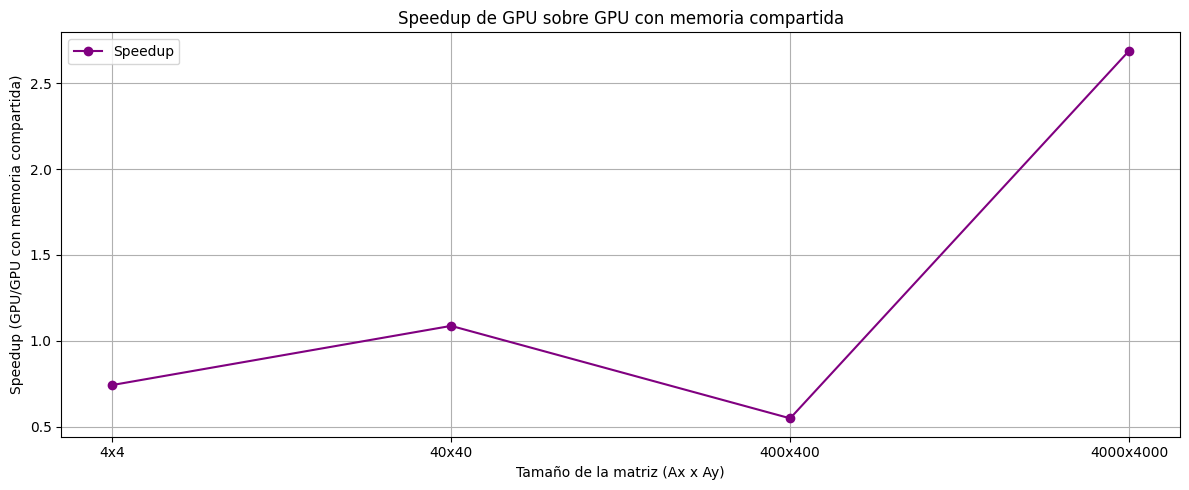

In [46]:
time_gpu = []
time_gpu_shared = []
Ax_list = [4,40,400,4_000]
Ay_list = [4,40,400,4_000]

for Ax, Ay in zip(Ax_list, Ay_list):
    A = np.random.rand(Ax, Ay)
    B = np.zeros(Ay)

    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)

    threads_per_block = 32
    blocks_total = math.ceil(A_device.shape[1] / threads_per_block)

    t_start = time.time()
    Avg_Cols_parallel[blocks_total, threads_per_block](A_device, B_device)
    t_finish = time.time()

    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Avg_Cols_parallel_shared[blocks_total, threads_per_block](A_device, B_device)
    t_finish = time.time()

    time_gpu_shared.append(t_finish-t_start)

speedup = np.array(time_gpu) / np.array(time_gpu_shared)

matrix_sizes = [f"{Ax}x{Ay}" for Ax, Ay in zip(Ax_list, Ay_list)]

_, (ax2) = plt.subplots(1, 1, figsize=(12, 5))

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax2.set_ylabel("Speedup (GPU/GPU con memoria compartida)")
ax2.set_title("Speedup de GPU sobre GPU con memoria compartida")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Analisis de la grafica de salida
Para tamaños de matrices pequeños (como 4x4 y 40x40), el beneficio de usar memoria compartida en la GPU es moderado, con un factor de aceleración alrededor de x1.3 a x1.4. Esto indica una mejora en la eficiencia, aunque no tan significativa en estos tamaños debido a la menor carga computacional.

A medida que el tamaño de la matriz aumenta, el uso de memoria compartida muestra una mejora notable. Para matrices de 400x400 y 4000x4000, el speedup incrementa significativamente, alcanzando un factor mayor a 2 en el caso de la matriz más grande. Esto nos da a entender que el uso de memoria compartida en GPU resulta especialmente beneficioso en tareas de mayor tamaño, reduciendo el tiempo de acceso a la memoria y mejorando la eficiencia general.

In [47]:
# GPU SHARED
B_gpu_rows_shared = np.zeros(Ax)

B_device = cuda.to_device(B_gpu_rows_shared)

threads_per_block = 32
blocks_total = math.ceil(A_device.shape[0] / threads_per_block)

t_start = time.time()
Avg_Rows_parallel_shared[blocks_total, threads_per_block](A_device, B_device)
t_finish = time.time()

B_gpu_rows_shared = B_device.copy_to_host()
t_gpu_rows_shared = t_finish - t_start

print("Output GPU \n", B_gpu_rows)
print()
print("Output GPU memoria compartida \n", B_gpu_rows_shared)
print()
print(f"Tiempo ejecución en GPU con memoria compartida = {t_gpu_rows_shared} s")
print()

# Speedup
speedup = t_cpu_rows / t_gpu_rows_shared
print(f"Speedup = {speedup}")

speedup = t_gpu_rows / t_gpu_rows_shared
print(f"Speedup memoria compartida = {speedup}")

Output GPU 
 [0.49362058 0.49473222 0.4963109  ... 0.49711769 0.50708163 0.50367516]

Output GPU memoria compartida 
 [0.49294449 0.50217059 0.50408383 ... 0.51293188 0.50416946 0.50207248]

Tiempo ejecución en GPU con memoria compartida = 0.14503860473632812 s

Speedup = 47.073339404539595
Speedup memoria compartida = 0.8649496330974987


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 125 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


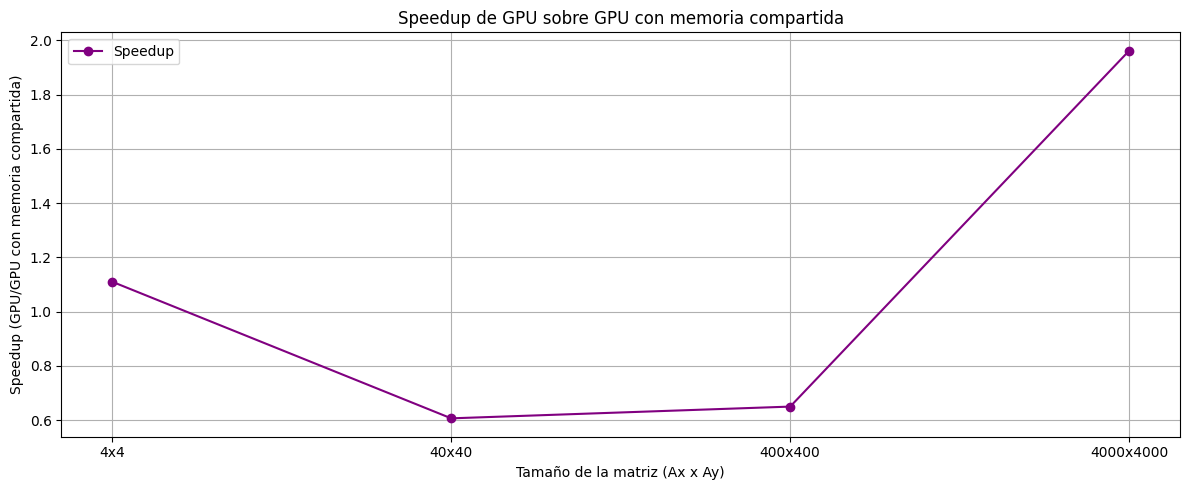

In [48]:
time_gpu = []
time_gpu_shared = []
Ax_list = [4,40,400,4_000]
Ay_list = [4,40,400,4_000]

for Ax, Ay in zip(Ax_list, Ay_list):
    A = np.random.rand(Ax, Ay)
    B = np.zeros(Ay)

    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)

    threads_per_block = 32
    blocks_total = math.ceil(A_device.shape[1] / threads_per_block)

    t_start = time.time()
    Avg_Rows_parallel[blocks_total, threads_per_block](A_device, B_device)
    t_finish = time.time()

    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Avg_Rows_parallel_shared[blocks_total, threads_per_block](A_device, B_device)
    t_finish = time.time()

    time_gpu_shared.append(t_finish-t_start)

speedup = np.array(time_gpu) / np.array(time_gpu_shared)

matrix_sizes = [f"{Ax}x{Ay}" for Ax, Ay in zip(Ax_list, Ay_list)]

_, (ax2) = plt.subplots(1, 1, figsize=(12, 5))

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax2.set_ylabel("Speedup (GPU/GPU con memoria compartida)")
ax2.set_title("Speedup de GPU sobre GPU con memoria compartida")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# 2.4 Optional assignment #1: Mean_3x3 (2 points)

In [49]:
def Mean_3x3_sequential(input, output):
    for x in range(input.shape[0]):
        for y in range(input.shape[1]):
            output[x, y] = 0.0
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if x + i >= 0 and x + i < input.shape[0] and \
                        y + j >= 0 and y + j < input.shape[1]:
                        output[x, y] += input[x + i, y + j]
            output[x, y] /= 9.0

@cuda.jit
def Mean_3x3_parallel(input, output):
    shared_mem = cuda.shared.array((16 + 2, 16 + 2), dtype=float32)
    rows, cols = input.shape
    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    if 0 <= x < rows and 0 <= y < cols:
        shared_mem[tx + 1, ty + 1] = input[x, y]
    else:
        shared_mem[tx + 1, ty + 1] = 0.0

    cuda.syncthreads()

    # Calcular la media 3x3 si estamos dentro del rango
    if x < rows and y < cols:
        total_sum = 0.0
        if y != 0 and y != cols-1 and x != 0 and x != rows-1:
            # Sumar los 8 vecinos y la celda central
            total_sum = (shared_mem[tx, ty] + shared_mem[tx, ty + 1] + shared_mem[tx, ty + 2] +
                        shared_mem[tx + 1, ty] + shared_mem[tx + 1, ty + 1] + shared_mem[tx + 1, ty + 2] +
                        shared_mem[tx + 2, ty] + shared_mem[tx + 2, ty + 1] + shared_mem[tx + 2, ty + 2])
        elif y == 0 and x == 0:
            total_sum = (shared_mem[tx + 1, ty + 1] + shared_mem[tx + 1, ty + 2] +
                         shared_mem[tx + 2, ty + 1] + shared_mem[tx + 2, ty + 2])
        elif y == 0 and x == rows-1:
            total_sum = (shared_mem[tx, ty + 1]     +  shared_mem[tx, ty + 2] +
                         shared_mem[tx + 1, ty + 1] +  shared_mem[tx + 1, ty + 2])
        elif y == cols-1 and x == rows-1:
            total_sum = (shared_mem[tx, ty]    +  shared_mem[tx, ty + 1] +
                        shared_mem[tx + 1, ty] +  shared_mem[tx + 1, ty + 1])
        elif y == cols-1 and x == 0:
            total_sum = (shared_mem[tx + 1, ty] + shared_mem[tx + 1, ty + 1] +
                         shared_mem[tx + 2, ty] + shared_mem[tx + 2, ty + 1])
        elif y == 0:
            total_sum = (shared_mem[tx, ty + 1] + shared_mem[tx, ty + 2] +
                        shared_mem[tx + 1, ty + 1] + shared_mem[tx + 1, ty + 2] +
                        shared_mem[tx + 2, ty + 1] + shared_mem[tx + 2, ty + 2])
        elif y == cols-1:
            total_sum = (shared_mem[tx, ty] + shared_mem[tx, ty + 1] +
                        shared_mem[tx + 1, ty] + shared_mem[tx + 1, ty + 1] +
                        shared_mem[tx + 2, ty] + shared_mem[tx + 2, ty + 1])
        elif x == 0:
            total_sum = (shared_mem[tx + 1, ty] + shared_mem[tx + 1, ty + 1] + shared_mem[tx + 1, ty + 2] +
                        shared_mem[tx + 2, ty] + shared_mem[tx + 2, ty + 1] + shared_mem[tx + 2, ty + 2])
        elif x == rows-1:
            total_sum = (shared_mem[tx, ty] + shared_mem[tx, ty + 1] + shared_mem[tx, ty + 2] +
                        shared_mem[tx + 1, ty] + shared_mem[tx + 1, ty + 1] + shared_mem[tx + 1, ty + 2])

        output[x, y] = total_sum / 9.0

In [50]:
np.random.seed(0)

Ax = 500
Ay = 500
A = np.random.rand(Ax, Ay)
B = np.zeros_like(A)

t_start = time.time()
Mean_3x3_sequential(A, B)
t_finish = time.time()

t_cpu = t_finish - t_start

print("Input \n", A)
print()
print("Output \n", B)
print()
print(f"Tiempo ejecución en CPU = {t_cpu} s")

Input 
 [[0.5488135  0.71518937 0.60276338 ... 0.40171354 0.24841347 0.50586638]
 [0.31038083 0.37303486 0.52497044 ... 0.93841202 0.22864655 0.67714114]
 [0.59288027 0.0100637  0.4758262  ... 0.11224999 0.04236405 0.22774099]
 ...
 [0.04027885 0.47565007 0.23954916 ... 0.86257219 0.78585522 0.86425687]
 [0.26993482 0.42351381 0.63561855 ... 0.56271762 0.35168929 0.28798926]
 [0.21022704 0.09253358 0.75865814 ... 0.50272661 0.68693019 0.1843027 ]]

Output 
 [[0.21637984 0.3416836  0.39015958 ... 0.30972799 0.33335479 0.18445195]
 [0.28337361 0.46154695 0.52289962 ... 0.34842103 0.37583868 0.21446362]
 [0.28557148 0.42141822 0.4884467  ... 0.43059867 0.4280333  0.25794777]
 ...
 [0.31307159 0.48448196 0.51958307 ... 0.63846398 0.6379794  0.42470454]
 [0.16801535 0.34955156 0.47562152 ... 0.57647788 0.56544888 0.35122484]
 [0.11068992 0.26560955 0.37219746 ... 0.28558861 0.28626174 0.16787905]]

Tiempo ejecución en CPU = 2.9756011962890625 s


In [51]:
B = np.zeros_like(A)

A_device = cuda.to_device(A)
B_device = cuda.to_device(B)

threads_per_block = (16,16)

blocks_X = math.ceil(B.shape[0] / threads_per_block[0])
blocks_Y = math.ceil(B.shape[1] / threads_per_block[1])
blocks_total = (blocks_X, blocks_Y)

t_start = time.time()
Mean_3x3_parallel[blocks_total, threads_per_block](A_device, B_device)
t_finish = time.time()

t_gpu = t_finish - t_start

B_par = B_device.copy_to_host()

print("Input \n", A)
print()
print("Output \n", B_par)
print()
print(f"Tiempo ejecución en GPU = {t_gpu} s")

Input 
 [[0.5488135  0.71518937 0.60276338 ... 0.40171354 0.24841347 0.50586638]
 [0.31038083 0.37303486 0.52497044 ... 0.93841202 0.22864655 0.67714114]
 [0.59288027 0.0100637  0.4758262  ... 0.11224999 0.04236405 0.22774099]
 ...
 [0.04027885 0.47565007 0.23954916 ... 0.86257219 0.78585522 0.86425687]
 [0.26993482 0.42351381 0.63561855 ... 0.56271762 0.35168929 0.28798926]
 [0.21022704 0.09253358 0.75865814 ... 0.50272661 0.68693019 0.1843027 ]]

Output 
 [[0.21637983 0.3416836  0.39015961 ... 0.30972799 0.33335479 0.18445195]
 [0.28337359 0.46154695 0.52289963 ... 0.34842104 0.3758387  0.21446362]
 [0.28557147 0.42141822 0.48844671 ... 0.43059868 0.42803327 0.25794776]
 ...
 [0.31307162 0.48448202 0.51958312 ... 0.63846397 0.63797935 0.42470455]
 [0.16801535 0.34955155 0.47562154 ... 0.5764779  0.56544892 0.35122485]
 [0.11068992 0.26560956 0.37219744 ... 0.28558861 0.28626174 0.16787904]]

Tiempo ejecución en GPU = 0.8296108245849609 s


In [52]:
speedup = t_cpu / t_gpu
print(f"Speedup = {speedup}")

Speedup = 3.586743456219609


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


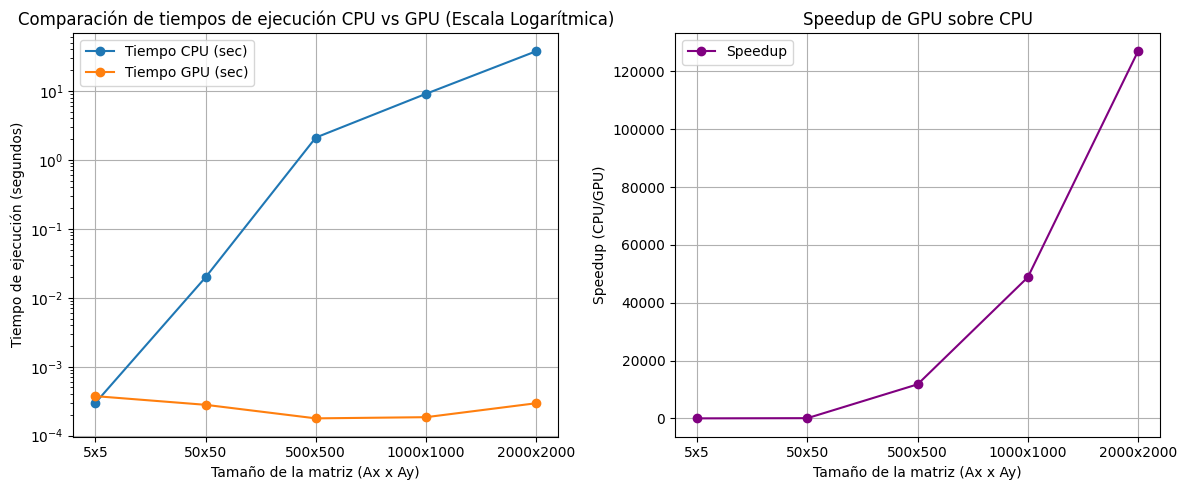

In [53]:
time_cpu = []
time_gpu = []
Ax_list = [5,50,500,1_000,2_000]
Ay_list = [5,50,500,1_000,2_000]

for Ax, Ay in zip(Ax_list, Ay_list):
    A = np.random.rand(Ax, Ay)
    B = np.zeros_like(A)

    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)

    blocks_X = math.ceil(B.shape[0] / threads_per_block[0])
    blocks_Y = math.ceil(B.shape[1] / threads_per_block[1])
    blocks_total = (blocks_X, blocks_Y)

    t_start = time.time()
    Mean_3x3_parallel[blocks_total, threads_per_block](A_device, B_device)
    t_finish = time.time()

    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Mean_3x3_sequential(A, B)
    t_finish = time.time()

    time_cpu.append(t_finish-t_start)

speedup = np.array(time_cpu) / np.array(time_gpu)

matrix_sizes = [f"{Ax}x{Ay}" for Ax, Ay in zip(Ax_list, Ay_list)]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(matrix_sizes, time_cpu, label='Tiempo CPU (sec)', marker='o')
ax1.plot(matrix_sizes, time_gpu, label='Tiempo GPU (sec)', marker='o')
ax1.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución CPU vs GPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de la matriz (Ax x Ay)")
ax2.set_ylabel("Speedup (CPU/GPU)")
ax2.set_title("Speedup de GPU sobre CPU")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# 2.5 Optional assignment #2: Reduction approaches (3 points)

In [54]:
def Reduce_sequential(input, output):
    acum = 0
    for i in range(input.shape[0]):
        acum += input[i]
    output[0] = acum


N = 10_000_000
np.random.seed(0)
A = np.random.rand(N)
output = np.zeros(1)

t_start = time.time()
Reduce_sequential(A, output)
t_finish = time.time()

t_cpu = t_finish - t_start

print("Input \n", A)
print()
print("Output \n", output[0])
print()
print(f"Tiempo ejecución en CPU = {t_cpu} s")

Input 
 [0.5488135  0.71518937 0.60276338 ... 0.7016828  0.45616281 0.14553608]

Output 
 4999995.59696607

Tiempo ejecución en CPU = 2.7033870220184326 s


## Reduction #1: Interleaved addressing with divergent branching

In [55]:
@cuda.jit
def reduce_interleaved_divergent(input, output):
    sSrc = cuda.shared.array(16, dtype=float32)
    sDst = cuda.shared.array(16, dtype=float32)


    tid = cuda.threadIdx.x
    bid = cuda.blockIdx.x
    bx = cuda.blockDim.x

    if tid + bid * bx < input.size:
        sSrc[tid] = input[tid + bid * bx]
    else:
        sSrc[tid] = 0
    cuda.syncthreads()

    stride = 2
    while stride <= bx:
        if tid % stride == 0:
            if tid + stride // 2 < bx:
                # sSrc[tid + stride // 2]
                sDst[tid] = sSrc[tid] + sSrc[tid + stride // 2]
        cuda.syncthreads()

        sSrc[tid] = sDst[tid]
        cuda.syncthreads()

        # Como se indica arriba, se multiplica stride * 2
        stride *= 2

    # El primer hilo de todos tiene el privilegio de guardar el resultado
    if tid == 0:
        cuda.atomic.add(output, 0, sDst[0])

In [56]:
output = np.zeros(1)

input_device = cuda.to_device(A)
output_device = cuda.to_device(output)

threads_per_block = 32
blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

t_start = time.time()
reduce_interleaved_divergent[blocks_per_grid, threads_per_block](input_device, output_device)
t_finish = time.time()

t_gpu_1 = t_finish - t_start

output = output_device.copy_to_host()

print("Input \n", A)
print()
print("Output \n", output[0])
print()
print(f"Tiempo ejecución en GPU = {t_gpu_1} s")

Input 
 [0.5488135  0.71518937 0.60276338 ... 0.7016828  0.45616281 0.14553608]

Output 
 4999995.596780777

Tiempo ejecución en GPU = 0.2949028015136719 s


In [57]:
speedup = t_cpu / t_gpu_1
print(f"Speedup = {speedup}")

Speedup = 9.167044219798983


<ipython-input-58-c2c5971db26c>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)
<ipython-input-58-c2c5971db26c>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)


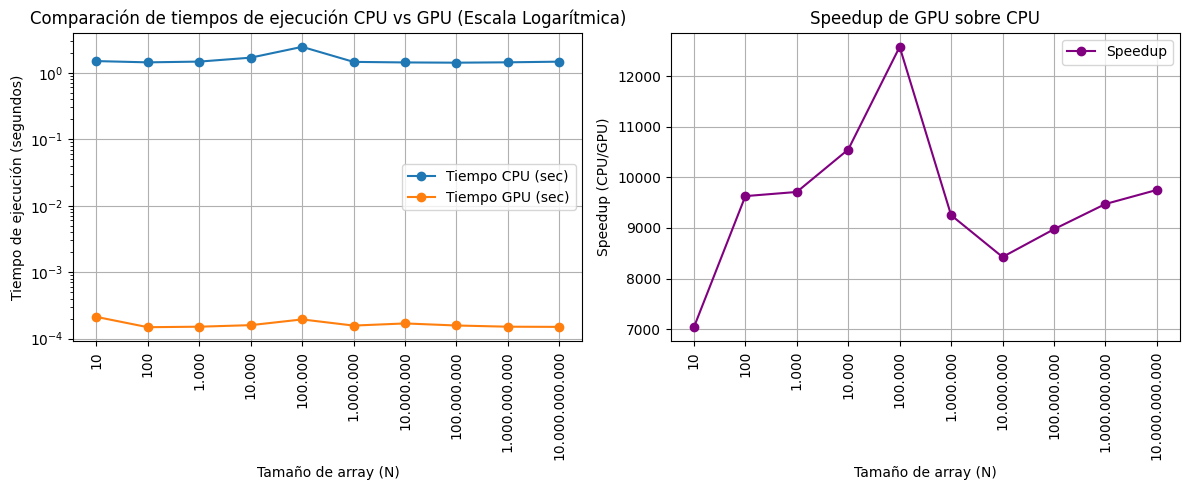

In [58]:
time_cpu = []
time_gpu = []
N_list = [10**i for i in range(1, 11)]

for N in N_list:
    N = 10_000_000
    np.random.seed(0)
    A = np.random.rand(N)
    output = np.zeros(1)

    A_device = cuda.to_device(A)
    output_device = cuda.to_device(output)

    threads_per_block = 32
    blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

    t_start = time.time()
    reduce_interleaved_divergent[blocks_per_grid, threads_per_block](input_device, output_device)
    t_finish = time.time()


    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Reduce_sequential(A, output)
    t_finish = time.time()

    time_cpu.append(t_finish-t_start)

speedup = np.array(time_cpu) / np.array(time_gpu)

matrix_sizes = [f"{N}" for N in N_list]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(matrix_sizes, time_cpu, label='Tiempo CPU (sec)', marker='o')
ax1.plot(matrix_sizes, time_gpu, label='Tiempo GPU (sec)', marker='o')
ax1.set_xlabel("Tamaño de array (N)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución CPU vs GPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)
ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de array (N)")
ax2.set_ylabel("Speedup (CPU/GPU)")
ax2.set_title("Speedup de GPU sobre CPU")
ax2.legend()
ax2.grid(True)
ax2.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

plt.tight_layout()
plt.show()

La gráfica de tiempos en escala logarítmica muestra que, para todos los tamaños de array, la GPU es significativamente más rápida que la CPU en la operación de suma.

En la CPU, el tiempo de ejecución se mantiene estable en torno a $10^0$
  segundos (1 segundo) para tamaños pequeños, pero la gráfica sugiere ligeras variaciones, posiblemente por fluctuaciones en el rendimiento de la CPU o por caché/memoria en diferentes tamaños de datos.

En la GPU, el tiempo de ejecución se estabiliza en torno a $10^{-3}-10^{-4}$
  segundos para la mayoría de los tamaños, siendo consistentemente más rápido que la CPU. Este comportamiento indica que la GPU maneja la carga de manera más eficiente para operaciones de suma acumulada en paralelo.

## Reduction #2: Interleaved addressing with no divergent branching

In [59]:
@cuda.jit
def reduce_interleaved_no_divergent(input, output):
    sSrc = cuda.shared.array(shape=16, dtype=float32)
    tid = cuda.threadIdx.x
    bid = cuda.blockIdx.x
    bx = cuda.blockDim.x

    idx = tid + bid * bx
    if idx < input.size:
        sSrc[tid] = input[idx]
    else:
        sSrc[tid] = 0.0
    cuda.syncthreads()

    stride = 1
    while stride < bx:
        index = tid + stride
        if index < bx:
            sSrc[tid] += sSrc[index]
        cuda.syncthreads()
        stride *= 2

    if tid == 0:
        cuda.atomic.add(output, 0, sSrc[0])

In [60]:
output = np.zeros(1)

input_device = cuda.to_device(A)
output_device = cuda.to_device(output)

threads_per_block = 32
blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

t_start = time.time()
reduce_interleaved_no_divergent[blocks_per_grid, threads_per_block](input_device, output_device)
t_finish = time.time()

t_gpu_2 = t_finish - t_start

output = output_device.copy_to_host()

print("Input \n", A)
print()
print("Output \n", output[0])
print()
print(f"Tiempo ejecución en GPU = {t_gpu_1} s")

Input 
 [0.5488135  0.71518937 0.60276338 ... 0.7016828  0.45616281 0.14553608]

Output 
 4999995.596780777

Tiempo ejecución en GPU = 0.2949028015136719 s


In [61]:
speedup = t_cpu / t_gpu_2
print(f"Speedup = {speedup}")

Speedup = 20.37898590577249


<ipython-input-62-6d4616906fd9>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)
<ipython-input-62-6d4616906fd9>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)


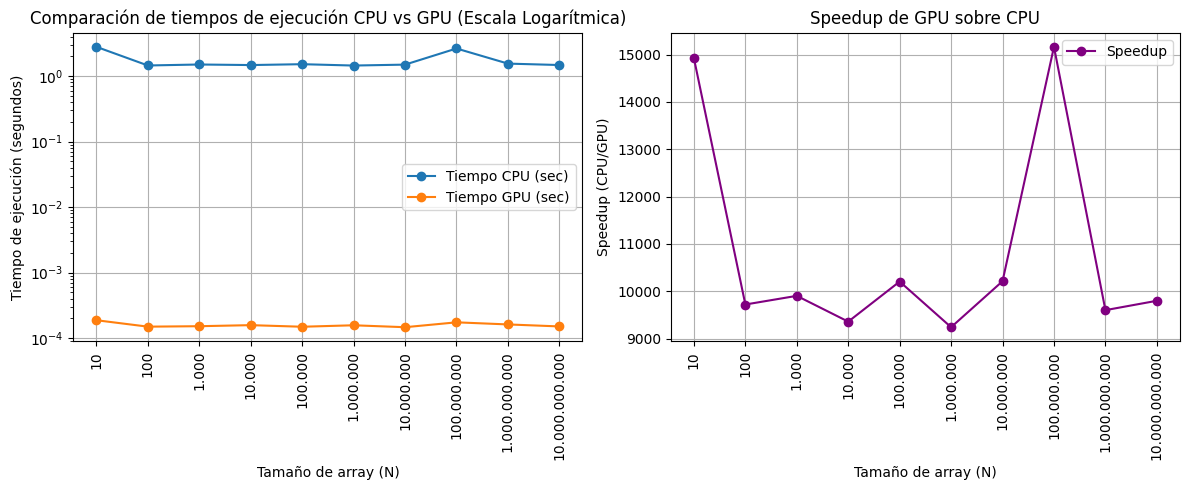

In [62]:
time_cpu = []
time_gpu = []
N_list = [10**i for i in range(1, 11)]

for N in N_list:
    N = 10_000_000
    np.random.seed(0)
    A = np.random.rand(N)
    output = np.zeros(1)

    A_device = cuda.to_device(A)
    output_device = cuda.to_device(output)

    threads_per_block = 32
    blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

    t_start = time.time()
    reduce_interleaved_no_divergent[blocks_per_grid, threads_per_block](input_device, output_device)
    t_finish = time.time()


    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Reduce_sequential(A, output)
    t_finish = time.time()

    time_cpu.append(t_finish-t_start)

speedup = np.array(time_cpu) / np.array(time_gpu)

matrix_sizes = [f"{N}" for N in N_list]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(matrix_sizes, time_cpu, label='Tiempo CPU (sec)', marker='o')
ax1.plot(matrix_sizes, time_gpu, label='Tiempo GPU (sec)', marker='o')
ax1.set_xlabel("Tamaño de array (N)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución CPU vs GPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)
ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de array (N)")
ax2.set_ylabel("Speedup (CPU/GPU)")
ax2.set_title("Speedup de GPU sobre CPU")
ax2.legend()
ax2.grid(True)
ax2.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

plt.tight_layout()
plt.show()

## Reduction #3: Sequential addressing

In [63]:
@cuda.jit
def reduce_sequential_addressing(input, output):
    sSrc = cuda.shared.array(16, dtype=float32)

    tid = cuda.threadIdx.x
    bid = cuda.blockIdx.x
    bx = cuda.blockDim.x

    if tid + bid * bx < input.size:
        sSrc[tid] = input[tid + bid * bx]
    else:
        sSrc[tid] = 0
    cuda.syncthreads()

    stride = 1
    while stride < bx:
        index = 2 * stride * tid
        if index + stride < bx:
            sSrc[index] += sSrc[index + stride]
        cuda.syncthreads()

        stride *= 2

    if tid == 0:
        cuda.atomic.add(output, 0, sSrc[0])

In [64]:
output = np.zeros(1)

input_device = cuda.to_device(A)
output_device = cuda.to_device(output)

threads_per_block = 32
blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

t_start = time.time()
reduce_sequential_addressing[blocks_per_grid, threads_per_block](input_device, output_device)
t_finish = time.time()

t_gpu_3 = t_finish - t_start

output = output_device.copy_to_host()

print("Input \n", A)
print()
print("Output \n", output[0])
print()
print(f"Tiempo ejecución en GPU = {t_gpu_1} s")

Input 
 [0.5488135  0.71518937 0.60276338 ... 0.7016828  0.45616281 0.14553608]

Output 
 4999995.596780777

Tiempo ejecución en GPU = 0.2949028015136719 s


In [65]:
speedup = t_cpu / t_gpu_3
print(f"Speedup = {speedup}")

Speedup = 18.871373458844833


<ipython-input-66-a1b4885cd59f>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)
<ipython-input-66-a1b4885cd59f>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)


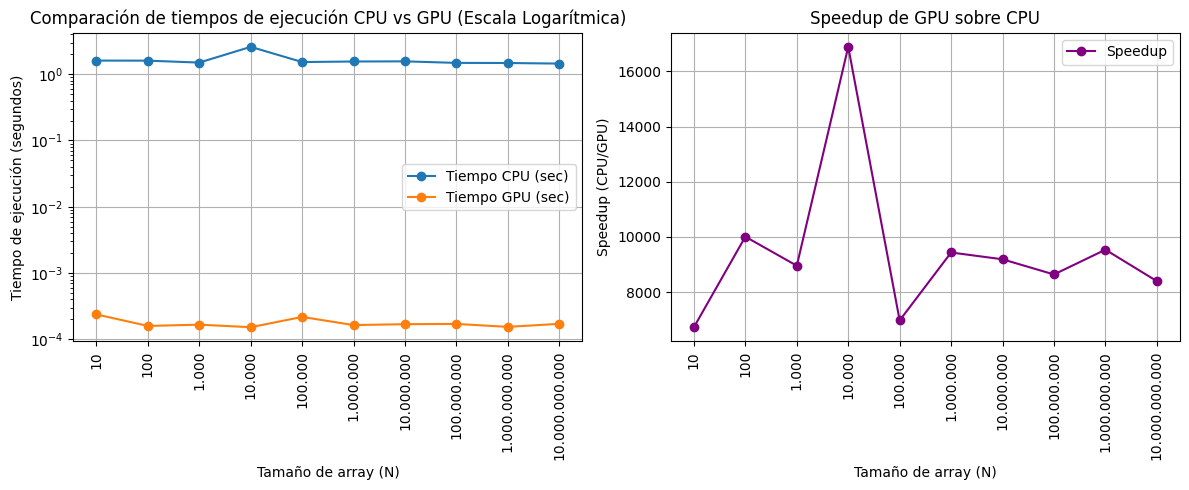

In [66]:
time_cpu = []
time_gpu = []
N_list = [10**i for i in range(1, 11)]

for N in N_list:
    N = 10_000_000
    np.random.seed(0)
    A = np.random.rand(N)
    output = np.zeros(1)

    A_device = cuda.to_device(A)
    output_device = cuda.to_device(output)

    threads_per_block = 32
    blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

    t_start = time.time()
    reduce_sequential_addressing[blocks_per_grid, threads_per_block](input_device, output_device)
    t_finish = time.time()


    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Reduce_sequential(A, output)
    t_finish = time.time()

    time_cpu.append(t_finish-t_start)

speedup = np.array(time_cpu) / np.array(time_gpu)

matrix_sizes = [f"{N}" for N in N_list]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(matrix_sizes, time_cpu, label='Tiempo CPU (sec)', marker='o')
ax1.plot(matrix_sizes, time_gpu, label='Tiempo GPU (sec)', marker='o')
ax1.set_xlabel("Tamaño de array (N)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución CPU vs GPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)
ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de array (N)")
ax2.set_ylabel("Speedup (CPU/GPU)")
ax2.set_title("Speedup de GPU sobre CPU")
ax2.legend()
ax2.grid(True)
ax2.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

plt.tight_layout()
plt.show()

## Reduction #4: Atomic addition

In [67]:
@cuda.jit
def reduce_atomic_addition(input, output):

    partial_sum = cuda.shared.array(16, dtype=float32)

    tid = cuda.threadIdx.x
    bid = cuda.blockIdx.x
    bx = cuda.blockDim.x

    if tid == 0:
        partial_sum[0] = 0.0
    cuda.syncthreads()

    if tid + bid * bx < input.size:
        cuda.atomic.add(partial_sum, 0, input[tid + bid * bx])
    cuda.syncthreads()

    if tid == 0:
        cuda.atomic.add(output, 0, partial_sum[0])

In [68]:
output = np.zeros(1)

input_device = cuda.to_device(A)
output_device = cuda.to_device(output)

threads_per_block = 32
blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

t_start = time.time()
reduce_atomic_addition[blocks_per_grid, threads_per_block](input_device, output_device)
t_finish = time.time()

t_gpu_atom = t_finish - t_start

output = output_device.copy_to_host()

print("Input \n", A)
print()
print("Output \n", output[0])
print()
print(f"Tiempo ejecución en GPU = {t_gpu_1} s")

Input 
 [0.5488135  0.71518937 0.60276338 ... 0.7016828  0.45616281 0.14553608]

Output 
 4999995.597089767

Tiempo ejecución en GPU = 0.2949028015136719 s


In [69]:
speedup = t_cpu / t_gpu_atom
print(f"Speedup = {speedup}")

Speedup = 15.745221788975538


<ipython-input-70-6e9deeb731d3>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)
<ipython-input-70-6e9deeb731d3>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)


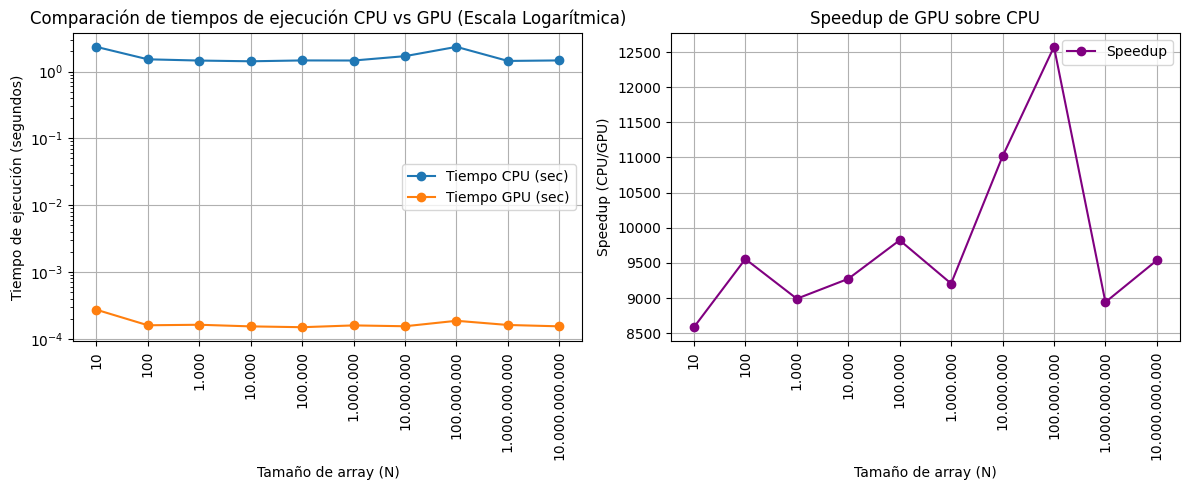

In [70]:
time_cpu = []
time_gpu = []
N_list = [10**i for i in range(1, 11)]

for N in N_list:
    N = 10_000_000
    np.random.seed(0)
    A = np.random.rand(N)
    output = np.zeros(1)

    A_device = cuda.to_device(A)
    output_device = cuda.to_device(output)

    threads_per_block = 32
    blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

    t_start = time.time()
    reduce_atomic_addition[blocks_per_grid, threads_per_block](input_device, output_device)
    t_finish = time.time()


    time_gpu.append(t_finish-t_start)

    t_start = time.time()
    Reduce_sequential(A, output)
    t_finish = time.time()

    time_cpu.append(t_finish-t_start)

speedup = np.array(time_cpu) / np.array(time_gpu)

matrix_sizes = [f"{N}" for N in N_list]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(matrix_sizes, time_cpu, label='Tiempo CPU (sec)', marker='o')
ax1.plot(matrix_sizes, time_gpu, label='Tiempo GPU (sec)', marker='o')
ax1.set_xlabel("Tamaño de array (N)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución CPU vs GPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)
ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

ax2.plot(matrix_sizes, speedup, label='Speedup', marker='o', color='purple')
ax2.set_xlabel("Tamaño de array (N)")
ax2.set_ylabel("Speedup (CPU/GPU)")
ax2.set_title("Speedup de GPU sobre CPU")
ax2.legend()
ax2.grid(True)
ax2.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

plt.tight_layout()
plt.show()

## Comparación de los diferentes algoritmos de suma de elementos de matrices

<ipython-input-74-f3c51bd53e6c>:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)


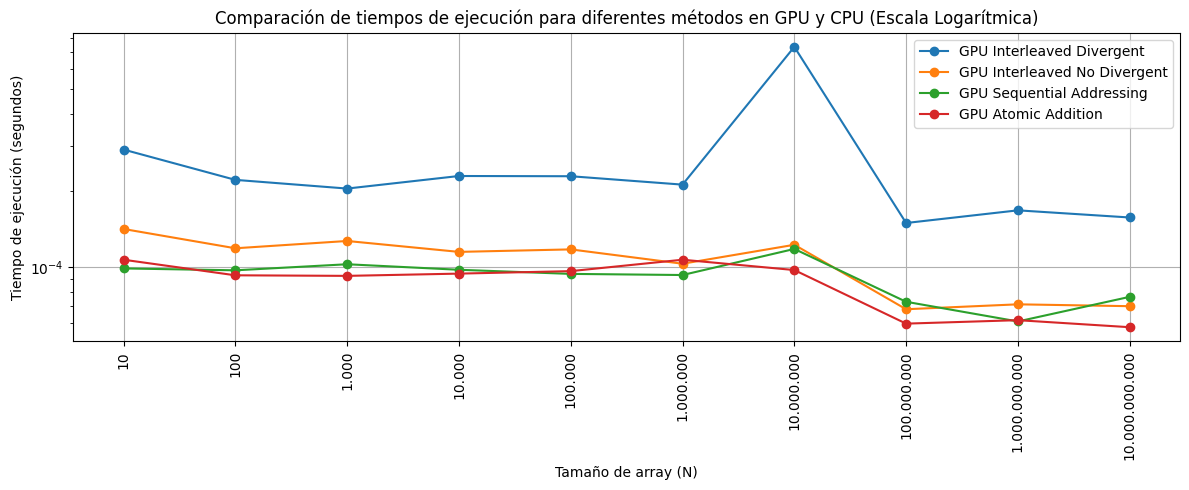

In [74]:
time_gpu_interleaved_divergent = []
time_gpu_interleaved_no_divergent = []
time_gpu_sequential_addressing = []
time_gpu_atomic_addition = []
N_list = [10**i for i in range(1, 11)]

for N in N_list:
    N = 10_000_000
    np.random.seed(0)
    A = np.random.rand(N)
    output = np.zeros(1)

    A_device = cuda.to_device(A)
    output_device = cuda.to_device(output)

    threads_per_block = 32
    blocks_per_grid = math.ceil(N + threads_per_block - 1 / threads_per_block)

    t_start = time.time()
    reduce_interleaved_divergent[blocks_per_grid, threads_per_block](input_device, output_device)
    t_finish = time.time()

    time_gpu_interleaved_divergent.append(t_finish-t_start)

    t_start = time.time()
    reduce_interleaved_no_divergent[blocks_per_grid, threads_per_block](input_device, output_device)
    t_finish = time.time()

    time_gpu_interleaved_no_divergent.append(t_finish-t_start)

    t_start = time.time()
    reduce_sequential_addressing[blocks_per_grid, threads_per_block](input_device, output_device)
    t_finish = time.time()

    time_gpu_sequential_addressing.append(t_finish-t_start)

    t_start = time.time()
    reduce_atomic_addition[blocks_per_grid, threads_per_block](input_device, output_device)
    t_finish = time.time()

    time_gpu_atomic_addition.append(t_finish-t_start)

matrix_sizes = [f"{N}" for N in N_list]

_, ax1 = plt.subplots(1, 1, figsize=(12, 5))

# Graficar tiempos para cada método
ax1.plot(matrix_sizes, time_gpu_interleaved_divergent, label='GPU Interleaved Divergent', marker='o')
ax1.plot(matrix_sizes, time_gpu_interleaved_no_divergent, label='GPU Interleaved No Divergent', marker='o')
ax1.plot(matrix_sizes, time_gpu_sequential_addressing, label='GPU Sequential Addressing', marker='o')
ax1.plot(matrix_sizes, time_gpu_atomic_addition, label='GPU Atomic Addition', marker='o')

# Personalización del gráfico
ax1.set_xlabel("Tamaño de array (N)")
ax1.set_ylabel("Tiempo de ejecución (segundos)")
ax1.set_yscale("log")
ax1.set_title("Comparación de tiempos de ejecución para diferentes métodos en GPU y CPU (Escala Logarítmica)")
ax1.legend()
ax1.grid(True)
ax1.set_xticklabels([f"{int(N):,}".replace(",", ".") for N in N_list], rotation=90)

plt.tight_layout()
plt.show()

### Explicaciones

En la gráfica, tres de las implementaciones de reducción (`Interleaved No Divergent`, `Sequential Addressing` y `Atomic Addition`) están muy cercanas en rendimiento, mientras que `Interleaved Divergent` es significativamente más lenta. Esto se debe a que las tres primeras optimizan el uso de la memoria compartida y minimizan la inactividad de los hilos al evitar la divergencia. En contraste, Interleaved Divergent presenta divergencia de hilos, lo que significa que solo una fracción de los hilos trabaja en cada paso, causando ineficiencia y aumentando el tiempo de ejecución.